In [1]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\adult\adult_data_modify.csv')


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int64
 1   workclass       48842 non-null  int64
 2   fnlwgt          48842 non-null  int64
 3   education-num   48842 non-null  int64
 4   marital-status  48842 non-null  int64
 5   occupation      48842 non-null  int64
 6   relationship    48842 non-null  int64
 7   race            48842 non-null  int64
 8   sex             48842 non-null  int64
 9   capital-gain    48842 non-null  int64
 10  capital-loss    48842 non-null  int64
 11  hours-per-week  48842 non-null  int64
 12  native-country  48842 non-null  int64
 13  income          48842 non-null  int64
dtypes: int64(14)
memory usage: 5.2 MB


Learning the structure of the Bayesian Network...


  0%|          | 19/1000000 [00:04<72:10:39,  3.85it/s]


Bayesian Network Structure:
[('workclass', 'occupation'), ('workclass', 'race'), ('occupation', 'education-num'), ('race', 'native-country'), ('education-num', 'income'), ('income', 'capital-gain'), ('marital-status', 'relationship'), ('marital-status', 'age'), ('marital-status', 'capital-loss'), ('marital-status', 'sex'), ('marital-status', 'native-country'), ('relationship', 'income'), ('relationship', 'sex'), ('relationship', 'hours-per-week'), ('relationship', 'workclass'), ('relationship', 'education-num'), ('relationship', 'race'), ('sex', 'occupation'), ('sex', 'workclass')]


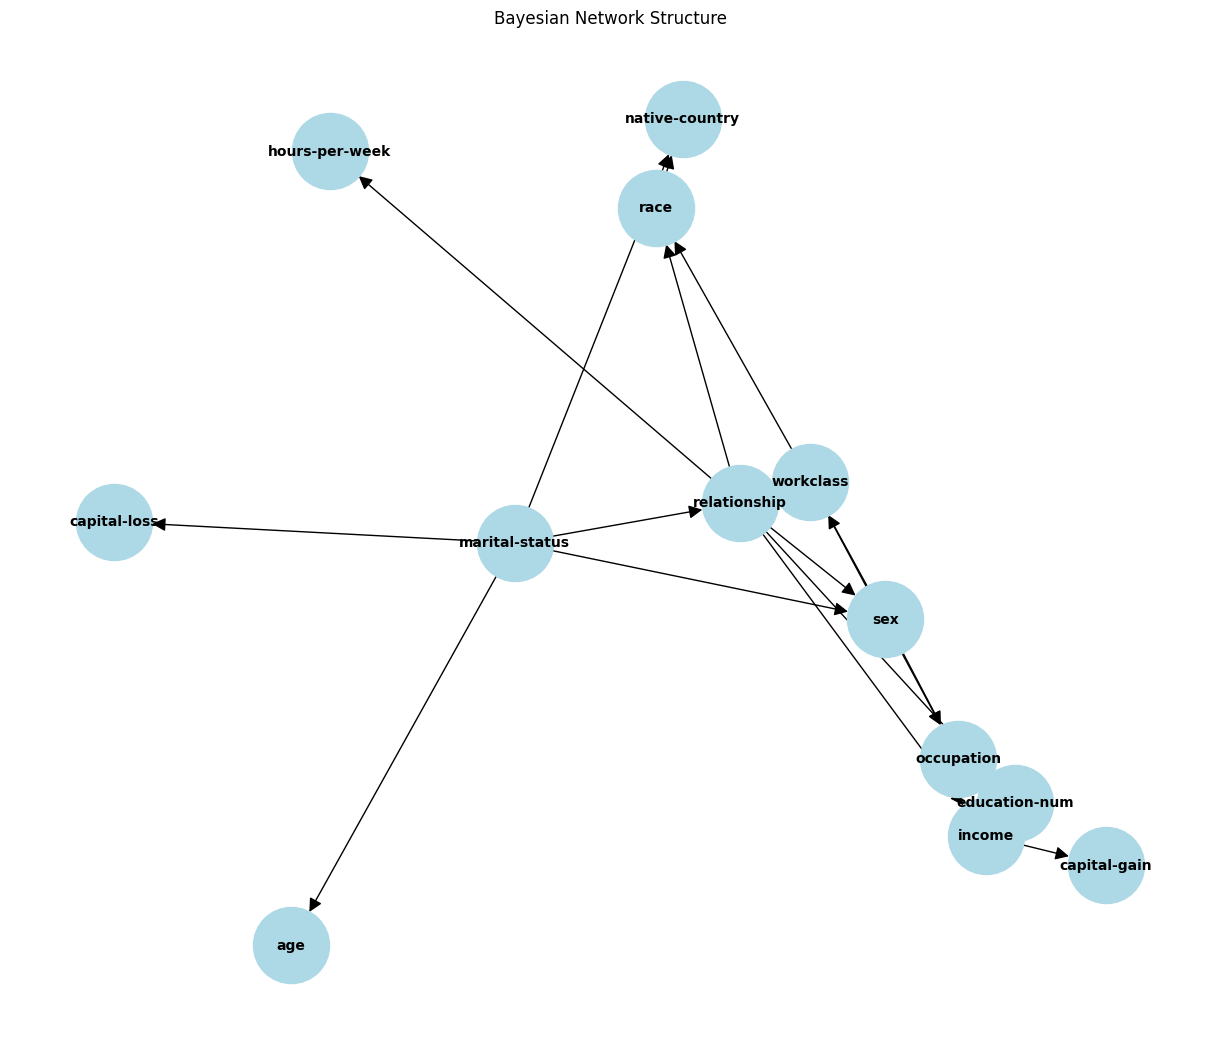

Fitting the Bayesian Network with data...


In [21]:



# Step 2: Identify missingness indicators
# Add missingness indicators for each column with missing values
missing_indicators = {}
for column in data.columns:
    if data[column].isnull().any():
        missing_indicators[f'R_{column}'] = data[column].isnull().astype(int)

# Add missingness indicators to the dataset
for key, value in missing_indicators.items():
    data[key] = value

# Drop rows with missing values temporarily for structure learning
data_complete = data.dropna()

# Step 3: Learn the structure of the Bayesian Network
print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data_complete)
model = hc.estimate(scoring_method=BicScore(data_complete))

# Create the Bayesian Network from the learned structure
bayesian_net = BayesianNetwork(model.edges())

# Step 4: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    # Create a networkx graph from the Bayesian Network
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Define layout
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    plt.title("Bayesian Network Structure")
    plt.show()

print("Bayesian Network Structure:")
print(bayesian_net.edges())
visualize_bayesian_network(bayesian_net)

# Step 5: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)


In [23]:
inference = VariableElimination(bayesian_net)

# Example Query 1: Probability of missingness for a variable
print("\nProbabilities of Missingness:")
for missing_var in missing_indicators.keys():
    query_result = inference.query(variables=[missing_var])
    print(f"{missing_var}:")
    print(query_result)

# Example Query 2: Joint probability of two variables
query_result = inference.query(variables=["sex", "marital-status","relationship"])
print("\nJoint Probability")
print(query_result)



Probabilities of Missingness:

Joint Probability
+--------+-------------------+-----------------+----------------------------------------+
| sex    | marital-status    | relationship    |   phi(sex,marital-status,relationship) |
+========+===================+=================+========================================+
| sex(1) | marital-status(1) | relationship(1) |                                 0.4037 |
+--------+-------------------+-----------------+----------------------------------------+
| sex(1) | marital-status(1) | relationship(2) |                                 0.0019 |
+--------+-------------------+-----------------+----------------------------------------+
| sex(1) | marital-status(1) | relationship(3) |                                 0.0029 |
+--------+-------------------+-----------------+----------------------------------------+
| sex(1) | marital-status(1) | relationship(4) |                                 0.0058 |
+--------+-------------------+-----------------+--

In [27]:
result = inference.query(variables=["workclass"], evidence={"sex": True})
print("Conditional Probability P(workclass | sex=True):")
print(result)

Conditional Probability P(workclass | sex=True):
+---------------+------------------+
| workclass     |   phi(workclass) |
+===============+==================+
| workclass(-1) |           0.0468 |
+---------------+------------------+
| workclass(1)  |           0.1248 |
+---------------+------------------+
| workclass(2)  |           0.6832 |
+---------------+------------------+
| workclass(3)  |           0.1445 |
+---------------+------------------+
| workclass(4)  |           0.0004 |
+---------------+------------------+
| workclass(5)  |           0.0002 |
+---------------+------------------+


In [24]:
query_result = inference.query(variables=["sex", "occupation"])
print("\nJoint Probability:")
print(query_result)


Joint Probability:
+--------+----------------+-----------------------+
| sex    | occupation     |   phi(sex,occupation) |
+========+================+=======================+
| sex(1) | occupation(-1) |                0.0314 |
+--------+----------------+-----------------------+
| sex(1) | occupation(1)  |                0.2070 |
+--------+----------------+-----------------------+
| sex(1) | occupation(2)  |                0.2753 |
+--------+----------------+-----------------------+
| sex(1) | occupation(3)  |                0.1547 |
+--------+----------------+-----------------------+
| sex(2) | occupation(-1) |                0.0261 |
+--------+----------------+-----------------------+
| sex(2) | occupation(1)  |                0.1589 |
+--------+----------------+-----------------------+
| sex(2) | occupation(2)  |                0.0328 |
+--------+----------------+-----------------------+
| sex(2) | occupation(3)  |                0.1138 |
+--------+----------------+-----------------

In [25]:
for missing_var in missing_indicators.keys():
    query_result = inference.query(variables=[missing_var])
    print(f"{missing_var}:")
    print(query_result)
missing_indicators

{}

Columns in the dataset after adding missingness indicators and proxy variables:
Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk', 'R_Age', 'R_Sex',
       'R_Job', 'R_Housing', 'R_Saving accounts', 'R_Checking account',
       'R_Credit amount', 'R_Duration', 'R_Purpose', 'Age*', 'Sex*', 'Job*',
       'Housing*', 'Saving accounts*', 'Checking account*', 'Credit amount*',
       'Duration*', 'Purpose*'],
      dtype='object')
Learning the structure of the Bayesian Network...


  0%|          | 8/1000000 [00:02<72:58:15,  3.81it/s] 


Nodes in the Bayesian Network:
['Sex', 'Sex*', 'Purpose', 'Risk', 'Checking account*', 'Job*', 'Job', 'Housing*', 'Housing', 'Saving accounts*', 'Saving accounts', 'Checking account', 'Purpose*']
Edges in the Bayesian Network:
[('Sex', 'Sex*'), ('Purpose', 'Sex'), ('Risk', 'Checking account*'), ('Checking account*', 'Checking account'), ('Job*', 'Job'), ('Housing*', 'Housing'), ('Saving accounts*', 'Saving accounts'), ('Purpose*', 'Purpose')]
Updated Nodes in the Bayesian Network:
['Sex', 'Sex*', 'Purpose', 'Risk', 'Checking account*', 'Job*', 'Job', 'Housing*', 'Housing', 'Saving accounts*', 'Saving accounts', 'Checking account', 'Purpose*', 'R_Age', 'R_Sex', 'R_Job', 'R_Housing', 'R_Saving accounts', 'R_Checking account', 'R_Credit amount', 'R_Duration', 'R_Purpose', 'Age*', 'Credit amount*', 'Duration*']
Updated Edges in the Bayesian Network:
[('Sex', 'Sex*'), ('Sex', 'R_Sex'), ('Purpose', 'Sex'), ('Purpose', 'R_Purpose'), ('Risk', 'Checking account*'), ('Checking account*', 'Checki

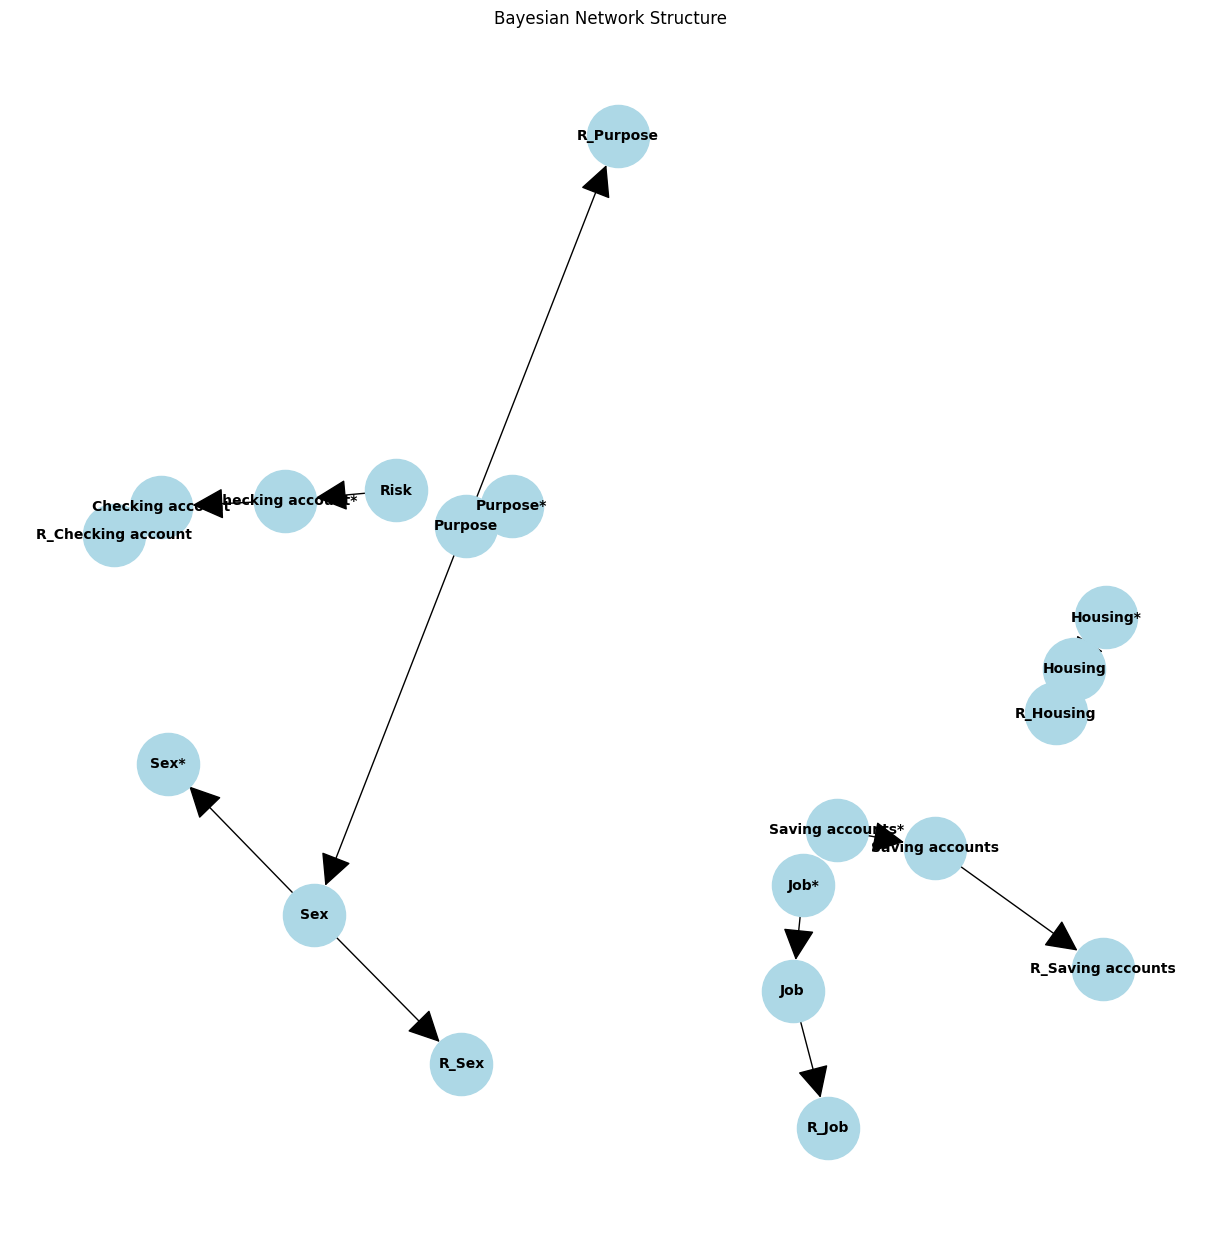

Fitting the Bayesian Network with data...

Probabilities of Missingness:
R_Age:
+----------+--------------+
| R_Age    |   phi(R_Age) |
+==========+==============+
| R_Age(0) |       0.6190 |
+----------+--------------+
| R_Age(1) |       0.3810 |
+----------+--------------+
R_Sex:
+----------+--------------+
| R_Sex    |   phi(R_Sex) |
+==========+==============+
| R_Sex(0) |       1.0000 |
+----------+--------------+
| R_Sex(1) |       0.0000 |
+----------+--------------+
R_Job:
+----------+--------------+
| R_Job    |   phi(R_Job) |
+==========+==============+
| R_Job(0) |       1.0000 |
+----------+--------------+
| R_Job(1) |       0.0000 |
+----------+--------------+
R_Housing:
+--------------+------------------+
| R_Housing    |   phi(R_Housing) |
+==============+==================+
| R_Housing(0) |           1.0000 |
+--------------+------------------+
| R_Housing(1) |           0.0000 |
+--------------+------------------+
R_Saving accounts:
+----------------------+------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Step 1: Load the dataset
# Replace 'path_to_dataset.csv' with the actual file path of your dataset
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\German Credit\german_credit_data_mcar30.csv')

# Step 2: Create missingness indicators for all columns with missing values
for column in data.columns:
    if data[column].isnull().any():
        data[f'R_{column}'] = data[column].isnull().astype(int)

# Step 3: Create proxy variables (e.g., O*) for observed data
for column in data.columns:
    if f'R_{column}' in data.columns:
        data[f'{column}*'] = data.apply(lambda row: row[column] if row[f'R_{column}'] == 0 else np.nan, axis=1)

# Step 4: Ensure missingness indicators and proxy variables are in the dataset
print("Columns in the dataset after adding missingness indicators and proxy variables:")
print(data.columns)

# Step 5: Drop rows with missing values temporarily for structure learning
# This ensures the algorithm has complete data to work with for learning
data_with_indicators = data.dropna()

# Step 6: Perform structure learning
print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data_with_indicators)
model = hc.estimate(scoring_method=BicScore(data_with_indicators))

# Create the Bayesian Network
bayesian_net = BayesianNetwork(model.edges())

# Debug: Print the nodes and edges in the Bayesian Network
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())
print("Edges in the Bayesian Network:")
print(bayesian_net.edges())

# Step 7: Add missingness indicators and proxy variables manually if excluded by the algorithm
for column in data.columns:
    if column.startswith('R_') and column not in bayesian_net.nodes():
        bayesian_net.add_node(column)
        original_var = column.replace('R_', '')
        if original_var in bayesian_net.nodes():
            bayesian_net.add_edge(original_var, column)

    if column.endswith('*') and column not in bayesian_net.nodes():
        bayesian_net.add_node(column)
        original_var = column.replace('*', '')
        if original_var in bayesian_net.nodes():
            bayesian_net.add_edge(original_var, column)
            if f'R_{original_var}' in bayesian_net.nodes():
                bayesian_net.add_edge(f'R_{original_var}', column)

# Debug: Print updated nodes and edges
print("Updated Nodes in the Bayesian Network:")
print(bayesian_net.nodes())
print("Updated Edges in the Bayesian Network:")
print(bayesian_net.edges())

# Step 8: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(
        G, pos, with_labels=True, node_size=2000, node_color="lightblue",
        font_size=10, font_weight="bold", arrowsize=50
    )
    plt.title("Bayesian Network Structure")
    plt.show()

visualize_bayesian_network(bayesian_net)

# Step 9: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)

# Step 10: Perform inference
inference = VariableElimination(bayesian_net)

# Example Query: Probabilities of missingness for each indicator
print("\nProbabilities of Missingness:")
for column in data.columns:
    if column.startswith('R_') and column in bayesian_net.nodes():
        query_result = inference.query(variables=[column])
        print(f"{column}:")
        print(query_result)

# Example Query: Joint probability of a proxy variable and its original variable
proxy_var = 'O*'
original_var = 'O'
if proxy_var in bayesian_net.nodes() and original_var in bayesian_net.nodes():
    query_result = inference.query(variables=[proxy_var, original_var])
    print(f"\nJoint Probability of {proxy_var} and {original_var}:")
    print(query_result)


In [ ]:
# Print nodes and edges
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())

print("Edges in the Bayesian Network:")
print(bayesian_net.edges())


Nodes in the Bayesian Network:
['Purpose', 'Sex', 'Risk', 'Checking account']
Edges in the Bayesian Network:
[('Purpose', 'Sex'), ('Risk', 'Checking account')]
